# Vergleich von Regularisierungstechniken bei Convolutional Neural Networks (CNNs)

In diesem Notebook werden wir verschiedene Regularisierungstechniken für Convolutional Neural Networks (CNNs) untersuchen, um ihre Auswirkungen auf die Modellleistung zu vergleichen. Wir verwenden den CIFAR-10-Datensatz, um ein einfaches CNN zu trainieren und Regularisierungen wie L1, L2, Dropout und Batch Normalization zu testen. Zusätzlich führen wir ein Hyperparameter-Tuning durch, um die besten Einstellungen für das Modell zu finden. Am Ende visualisieren wir die Ergebnisse und wenden das Modell auf Testbilder an, um seine Performance zu beurteilen.

**Nützlicher Tipp:**  
Regelmäßiges Experimentieren und Vergleichen von verschiedenen Regularisierungsansätzen ist eine bewährte Methode, um robuste Modelle zu entwickeln, die gut generalisieren. Behalte immer die Überanpassung (Overfitting) im Blick und nutze Regularisierung, um sie zu minimieren.


## Data Exploration

### Vorbereitung und Datensatz-Import

In dieser Zelle importieren wir die notwendigen Bibliotheken und laden den CIFAR-10-Datensatz. Es wird auch überprüft, ob eine GPU verfügbar ist, um die Rechenleistung zu optimieren. Achte darauf, die GPU in deiner Laufzeitumgebung zu aktivieren, um das Training zu beschleunigen.

### Aufgabe
- Richte deine Rechenumgebung so ein, dass TensorFlow Zugriff auf GPUs hat.

In [ ]:
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

# Überprüfen, ob eine GPU verfügbar ist und auf die GPU wechseln
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Deutsch:\nUm die GPU in Colab zu aktivieren, befolge diese Schritte:\n1. Gehe zum Menü: Runtime > Change runtime type.\n2. Wähle im erscheinenden Dialogfeld GPU aus dem Dropdown-Menü unter Hardware accelerator aus.\n3. Klicke auf Save (Speichern).\n\nTensorflow verwendet automatisch GPU für aufwendige Rechnungen")
    sys.exit("Keine GPU gefunden. Bitte die Runtime auf GPU schalten.")

# CIFAR-10 Datensatz laden
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0



Using GPU
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


### Visualisierung der Trainingsdaten

Hier visualisieren wir 25 Beispielbilder aus dem CIFAR-10-Datensatz. Dies hilft dir, die Daten besser zu verstehen, bevor wir ein Modell darauf trainieren. Jedes Bild ist mit dem entsprechenden Klassenlabel beschriftet.


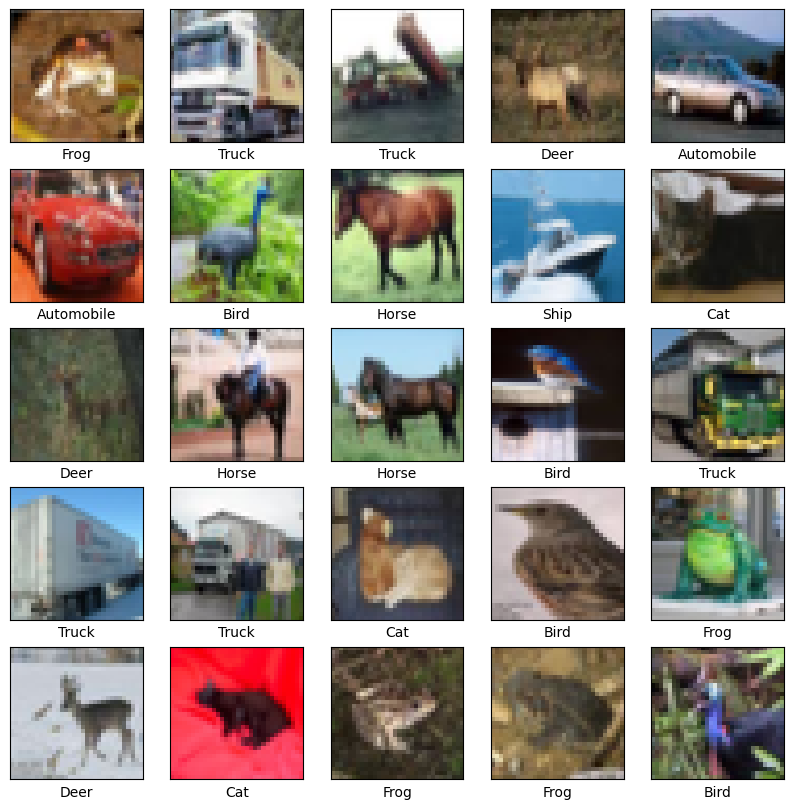

In [ ]:
# Klassenlabels für CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Einige Beispielbilder plotten
plt.figure(figsize=(10, 10))
for i in range(25):  # 25 Bilder (5x5 Grid)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])  # Keine x-Achsen-Ticks
    plt.yticks([])  # Keine y-Achsen-Ticks
    plt.grid(False)  # Kein Grid
    plt.imshow(x_train[i], cmap=plt.cm.binary)  # Bild plotten
    plt.xlabel(class_names[y_train[i][0]])  # Klasse als Label
plt.show()

## Modell erstellen & Trainieren

### Modellarchitektur erstellen

In dieser Zelle definieren wir eine flexible Funktion `create_model`, die ein Convolutional Neural Network (CNN) erstellt. Du kannst verschiedene Regularisierungstechniken wie L1, L2, Dropout und Batch Normalization anwenden. Die Lernrate des Optimizers kann ebenfalls angepasst werden.


**Nützlicher Tipp:**  
Beim Erstellen eines Modells ist es wichtig, mit einer einfachen Architektur zu beginnen und schrittweise Komplexität hinzuzufügen, z.B. durch zusätzliche Schichten oder Regularisierungstechniken. Dies hilft, die Auswirkungen jeder Änderung besser zu verstehen und Overfitting zu vermeiden.

### Aufgabe
 - Ergänze die `BatchNormalization`-Schicht nach der zweiten und dritten  `Conv2D`-Schicht, wenn `use_batchnorm=True` ist. Diese Schicht normalisiert die Ausgaben der Neuronen und kann das Training stabilisieren.
 - Ergänze die `Dropout`-Schicht nach der zweiten und dritten 'Pool'-Schicht, wenn `dropout_rate > 0` ist. Dropout hilft, Overfitting zu reduzieren, indem es zufällig Neuronen während des Trainings deaktiviert.


In [ ]:
# Einfache CNN-Architektur definieren
def create_model(reg_type=None, reg_strength=0.001, dropout_rate=0.0, use_batchnorm=False, learning_rate=0.001):
    model = models.Sequential()

    # Erste Convolutional + Pooling Schicht
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),
                            kernel_regularizer=reg_type(reg_strength) if reg_type else None))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

    # Zweite Convolutional + Pooling Schicht
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg_type(reg_strength) if reg_type else None))

##############################################
############ ENTER YOUR CODE HERE ############
##############################################

    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))



    # Dritte Convolutional Schicht
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=reg_type(reg_strength) if reg_type else None))
    if use_batchnorm:
        model.add(layers.BatchNormalization())

    # Flachlegung + Fully Connected Schicht
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=reg_type(reg_strength) if reg_type else None))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

##############################################
############ ENTER YOUR CODE HERE ############
##############################################

    # Output Layer
    model.add(layers.Dense(10, activation='softmax'))

    # Kompilieren des Modells
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Training der Modelle mit unterschiedlichen Regularisierungstechniken

Wir erstellen und trainieren mehrere Modelle mit verschiedenen Regularisierungsansätzen: ohne Regularisierung, L1, L2, Dropout und Batch Normalization. Jede Technik wird separat getestet, um ihre Wirkung auf die Modellleistung zu untersuchen.

**Nützlicher Tipp:**  
Regelmäßiges Monitoring der Modellleistung während des Trainings hilft, frühzeitig Anzeichen von Overfitting zu erkennen. Unterschiedliche Regularisierungstechniken haben unterschiedliche Effekte, daher ist es wichtig, sie systematisch zu vergleichen, um die beste Methode für dein Problem zu finden.



In [ ]:

# Modelle mit verschiedenen Regularisierungstechniken erstellen
model_no_reg = create_model()
model_l2_reg = create_model(reg_type=regularizers.l2)
model_l1_reg = create_model(reg_type=regularizers.l1)
model_dropout = create_model(dropout_rate=0.5)
model_batchnorm = create_model(use_batchnorm=True)

# Modelle trainieren
print("train no reg")
history_no_reg = model_no_reg.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
print("train L1 reg")
history_l1_reg = model_l1_reg.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
print("train L2 reg")
history_l2_reg = model_l2_reg.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
print("train dropout")
history_dropout = model_dropout.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
print("train batchnorm")
history_batchnorm = model_batchnorm.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


train no reg
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3596 - loss: 1.7312 - val_accuracy: 0.5457 - val_loss: 1.2627
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5753 - loss: 1.1976 - val_accuracy: 0.6090 - val_loss: 1.1066
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6412 - loss: 1.0223 - val_accuracy: 0.6190 - val_loss: 1.0804
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6741 - loss: 0.9276 - val_accuracy: 0.6648 - val_loss: 0.9693
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7060 - loss: 0.8451 - val_accuracy: 0.6732 - val_loss: 0.9565
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7310 - loss: 0.7784 - val_accuracy: 0.6865 - val_loss: 0.9088
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7459 - loss: 0.7239 - val_accuracy: 0.6947 - val_loss: 0.9002
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7657 - l

## Verschiedene Regularizations vergleichen


### Visualisierung der Trainingsfortschritte

Die Trainings- und Validierungsergebnisse werden für jedes Modell visualisiert. Wir vergleichen die Loss- und Accuracy-Werte für jedes Regularisierungsverfahren, um zu sehen, welche Technik am effektivsten ist.

**Nützlicher Tipp:**  
Das Plotten der Trainings- und Validierungskurven ist entscheidend, um zu sehen, wie gut dein Modell lernt. Achte auf Divergenzen zwischen Trainings- und Validierungskurven, da dies auf Overfitting hinweisen könnte. Vergleiche die Ergebnisse verschiedener Modelle direkt, um zu sehen, welche Regularisierungsmethode am effektivsten ist. Dabei genügt nicht nur ein Blick auf die Accuracy Metrik; auch der Train und Valid Loss sollte stets betrachtet werden.


### Aufgabe
- Interpretiere, wie sich verschiedene Regularisierungstechniken auf die Trainings- und Validierungskurven auswirken. Diskutiere, welche Techniken die beste Balance zwischen Bias und Varianz erreichen und Overfitting verhindern.

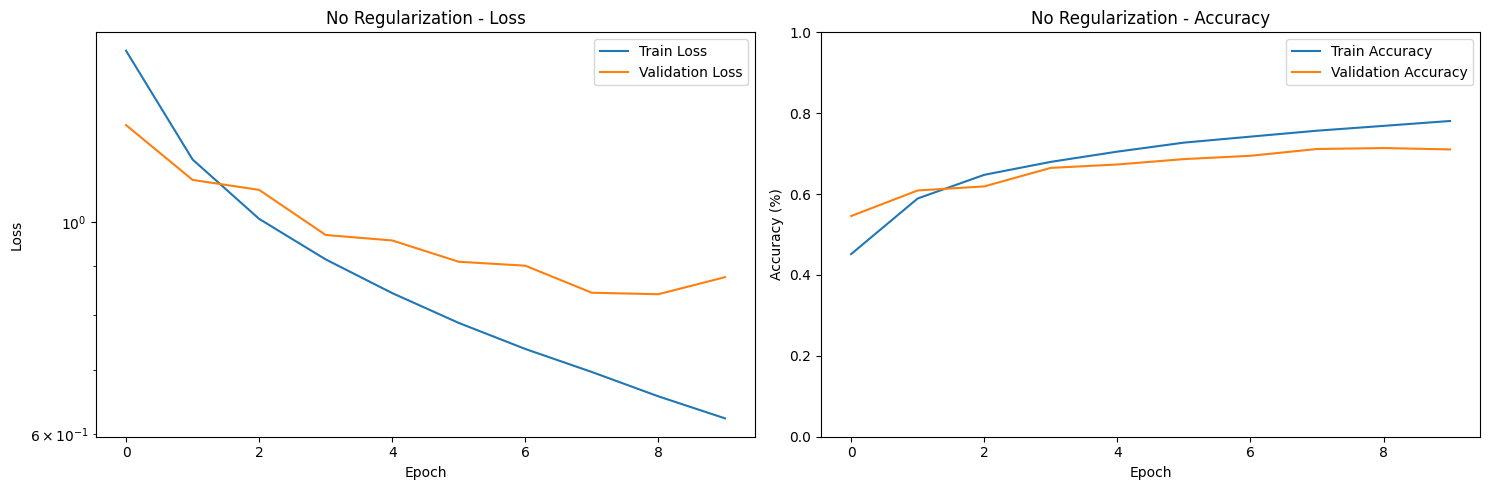

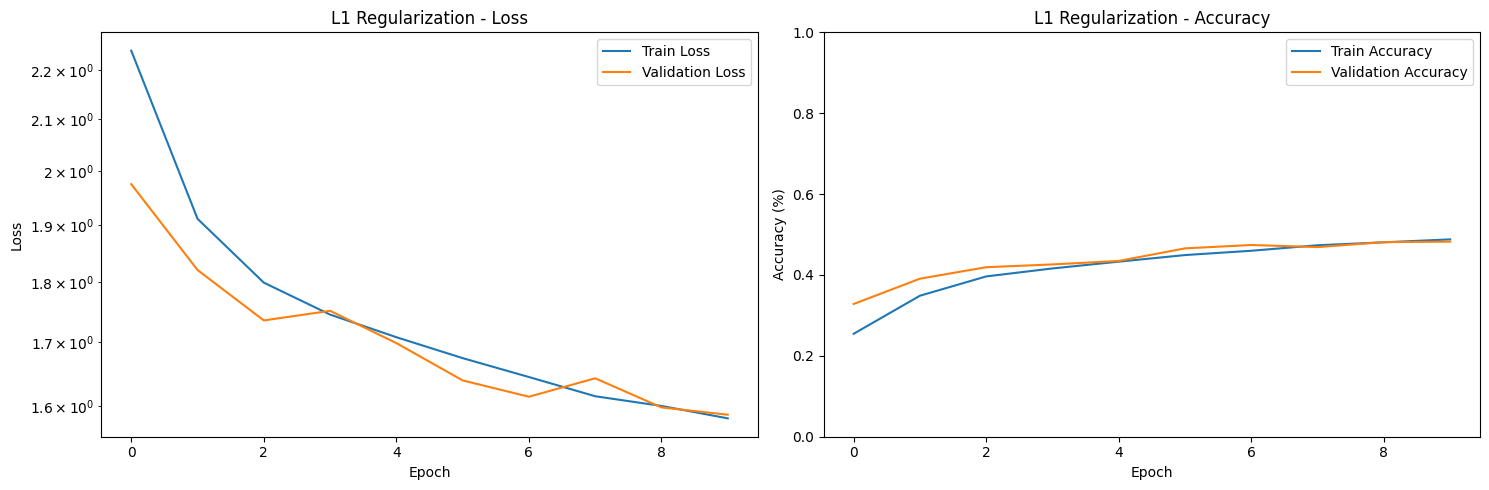

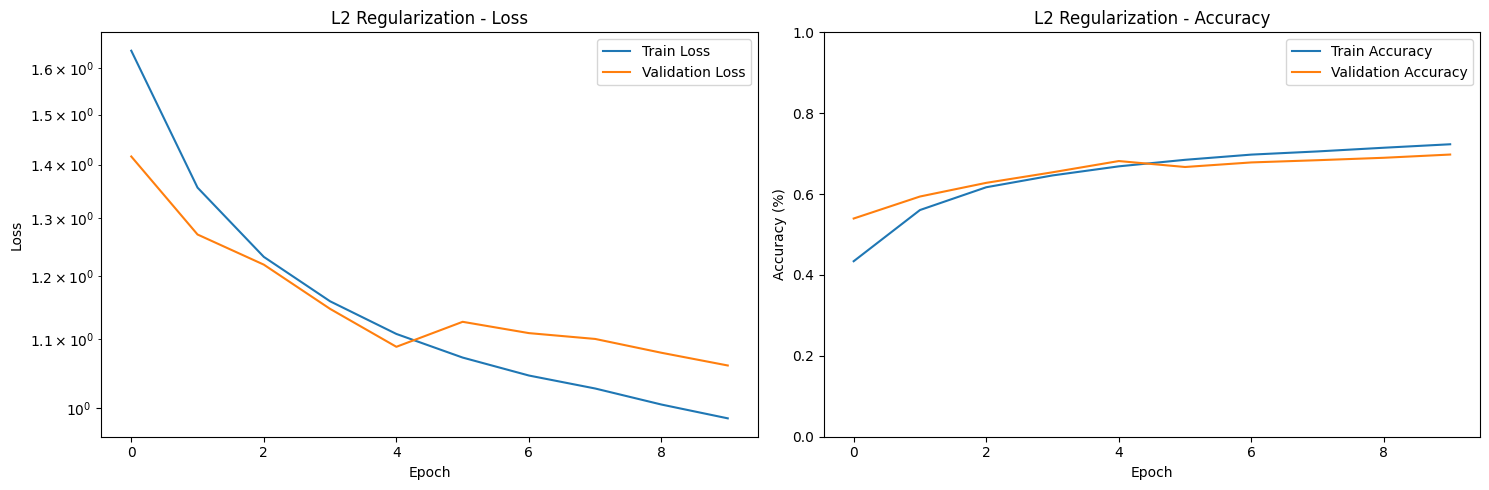

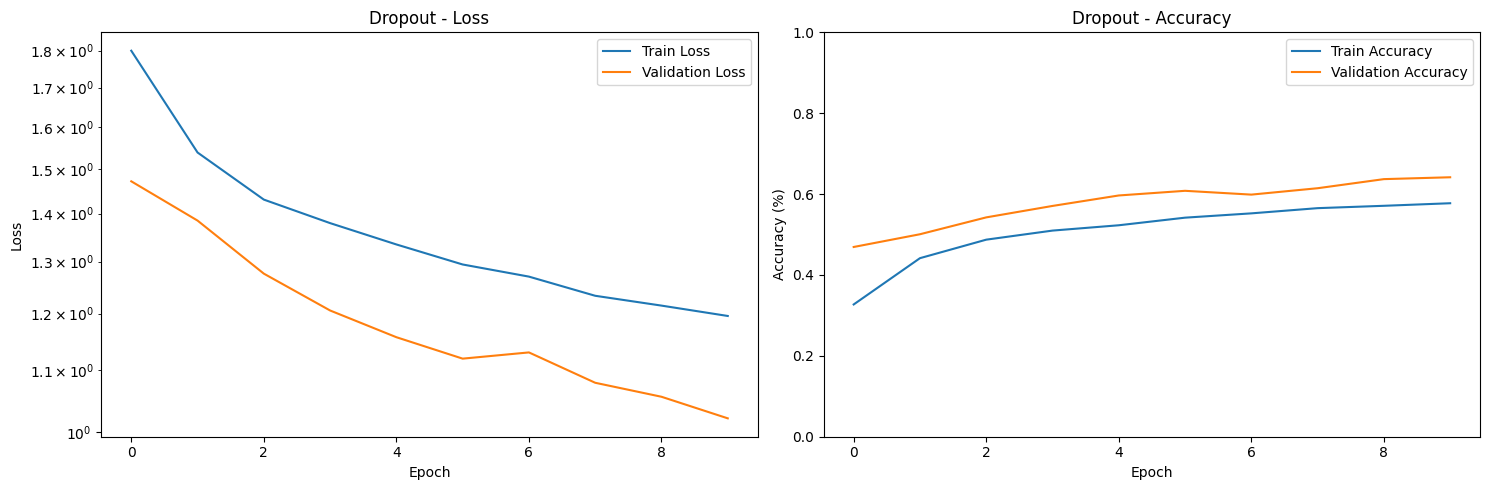

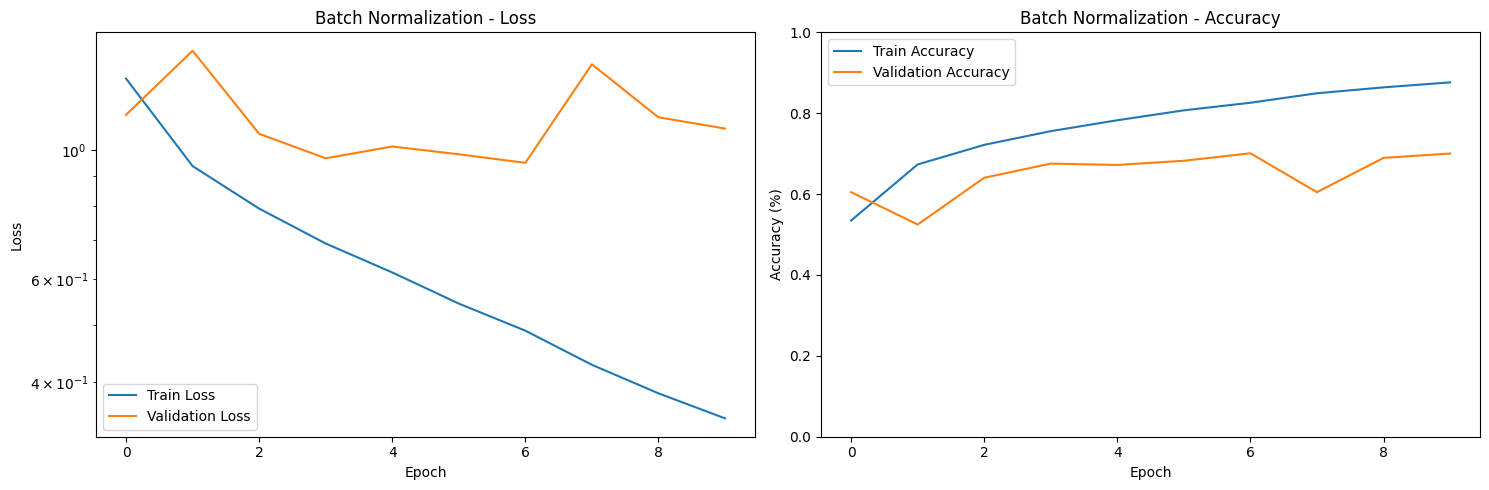

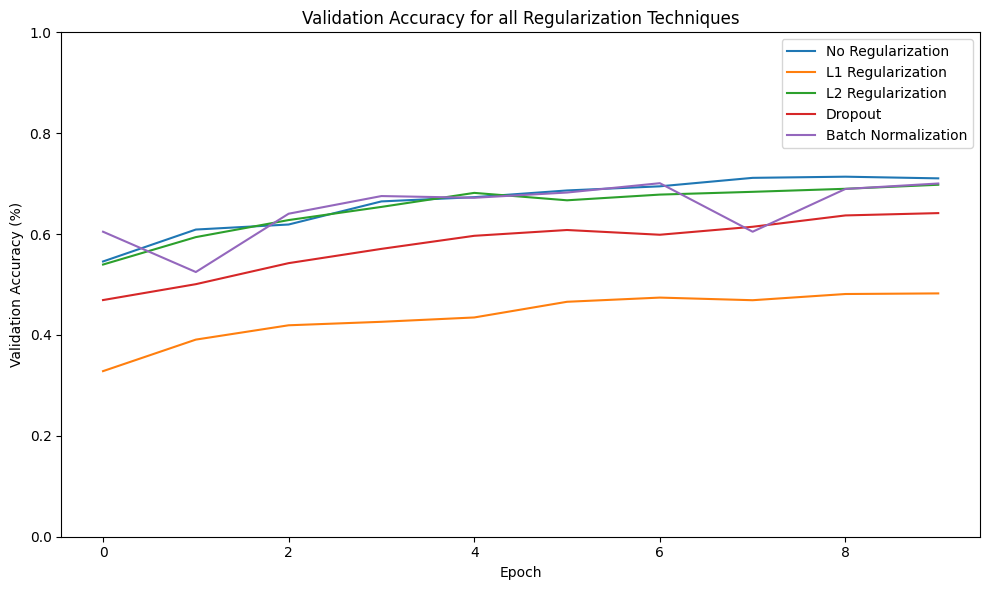

In [ ]:
import matplotlib.pyplot as plt

# Funktionen zum Plotten
def plot_metrics(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title(f'{title} - Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_yscale('log')
    axs[0].legend()

    # Accuracy
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].set_ylim(0, 1)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# No Regularization
plot_metrics(history_no_reg, 'No Regularization')


# L1 Regularization
plot_metrics(history_l1_reg, 'L1 Regularization')

# L2 Regularization
plot_metrics(history_l2_reg, 'L2 Regularization')

# Dropout
plot_metrics(history_dropout, 'Dropout')

# Batch Normalization
plot_metrics(history_batchnorm, 'Batch Normalization')

# Plot aller Validation Accuracies
plt.figure(figsize=(10, 6))
plt.plot(history_no_reg.history['val_accuracy'], label='No Regularization')
plt.plot(history_l1_reg.history['val_accuracy'], label='L1 Regularization')
plt.plot(history_l2_reg.history['val_accuracy'], label='L2 Regularization')
plt.plot(history_dropout.history['val_accuracy'], label='Dropout')
plt.plot(history_batchnorm.history['val_accuracy'], label='Batch Normalization')
plt.title('Validation Accuracy for all Regularization Techniques')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## Hyperparameter Tuning

Zuerst installieren wir das kerastuner Paket, welches Hyperpamareter Tuning automatisiert.

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


### Hyperparameter-Tuning mit Keras Tuner

Hier tunen wir die Hyperparameter. Dazu definieren wir das `CNNHyperModel`, um den Keras Tuner zu verwenden. Wir können zwischen verschiedenen Regularisierungstypen wählen und die Lernrate sowie die Stärke der Regularisierung optimieren.


**Nützlicher Tipp:**  
Hyperparameter-Tuning kann zeitaufwändig sein, aber es lohnt sich. Beginne mit einer kleineren Anzahl von Trials, um schnell ein Gefühl für geeignete Parameterbereiche zu bekommen. Verwende logische Schritte bei der Auswahl von Werten (z.B. logarithmische Skalen für Lernraten), um den Suchraum effizienter zu durchsuchen.



In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models, regularizers
from kerastuner import HyperModel, RandomSearch
import kerastuner as kt

# HyperModel Klasse definieren, die die create_model Funktion nutzt
class CNNHyperModel(HyperModel):
    def __init__(self, reg_type, use_batchnorm=False):
        self.reg_type = reg_type
        self.use_batchnorm = use_batchnorm

    def build(self, hp):
        reg_strength = hp.Float('reg_strength', min_value=1e-4, max_value=1e-2, sampling='LOG')
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

        # Passende Regularisierungsparameter je nach gewähltem Regularisierungstyp
        if self.reg_type == regularizers.l2 or self.reg_type == regularizers.l1:
            return create_model(reg_type=self.reg_type, reg_strength=reg_strength, learning_rate=learning_rate, use_batchnorm=self.use_batchnorm)
        else:
            return create_model(reg_type=None, dropout_rate=dropout_rate, learning_rate=learning_rate, use_batchnorm=self.use_batchnorm)

# Regularisation auswählen
#hypermodel = CNNHyperModel(reg_type=regularizers.l1)   ## L1
#hypermodel = CNNHyperModel(reg_type=regularizers.l2)   ## L2
hypermodel = CNNHyperModel(reg_type=None)              ## Dropout

# Anzahl an Kombinationen, die getestet werden sollen
num_trials = 6

# RandomSearch Tuner definieren
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=num_trials,  # Anzahl der verschiedenen Konfigurationen, die getestet werden sollen
    executions_per_trial=1,  # Anzahl der Trainingsläufe pro Konfiguration
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# Hyperparameter-Tuning ausführen
tuner.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

# Beste Hyperparameter anzeigen
final_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Beste Regularisierungsstärke: {final_hps.get('reg_strength')}")
print(f"Beste Dropout-Rate: {final_hps.get('dropout_rate')}")
print(f"Beste Lernrate: {final_hps.get('learning_rate')}")


Trial 6 Complete [00h 00m 41s]
val_accuracy: 0.5027999877929688

Best val_accuracy So Far: 0.6043000221252441
Total elapsed time: 00h 03m 24s
Beste Regularisierungsstärke: 0.0004176467208601923
Beste Dropout-Rate: 0.30000000000000004
Beste Lernrate: 0.0003715609375637089


In [ ]:
# Um neues Tuning zu starten, statt das alte erneut zu betrachten
#!rm hyperparam_tuning/cnn_tuning/tuner0.json


### Visualisierung der Hyperparameter-Tuning-Ergebnisse

Nach dem Hyperparameter-Tuning visualisieren wir die Ergebnisse. Dies zeigt, wie sich verschiedene Lernraten und Regularisierungsstärken auf die Validierungsgenauigkeit auswirken.

**Nützlicher Tipp:**  
Nach dem Hyperparameter-Tuning ist es hilfreich, die besten Modelle und ihre Hyperparameter zu visualisieren. Dies ermöglicht es dir, nicht nur das beste Modell auszuwählen, sondern auch zu verstehen, wie verschiedene Hyperparameter die Modellleistung beeinflussen, was bei zukünftigen Projekten wertvoll sein kann.


### Aufgabe
- Analysiere die Ergebnisse der Hyperparameter-Suche. Diskutiere, wie sich verschiedene Lernraten und Regularisierungsstärken auf die Modellleistung auswirken und welche Kombination die besten Ergebnisse liefert.


In [ ]:
import matplotlib.pyplot as plt

# Ergebnisse des Tuners abrufen
tuner.results_summary()

# Liste der besten Hyperparameter-Kombinationen abrufen
best_hps = tuner.get_best_hyperparameters(num_trials=num_trials)

# Extrahiere die Werte für die Lernrate und die Regularisierungsstärke/Dropout-Rate
learning_rates = [hp.get('learning_rate') for hp in best_hps]
val_accuracies = [hp.get('val_accuracy') for hp in best_hps]
if hypermodel.reg_type:
    reg_strengths = [hp.get('reg_strength') for hp in best_hps]
    reg_type = 'Regularisierungsstärke'
else:
    reg_strengths = [hp.get('dropout_rate') for hp in best_hps]
    reg_type = 'Dropout-Rate'

# Visualisierung der Ergebnisse
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot für Lernrate vs. Validierungsgenauigkeit
#val_accuracies = [tuner.oracle.get_trial(trial_id).metrics.get_best_value('val_accuracy') for trial_id in tuner.oracle.trials]
print(len(learning_rates), len(val_accuracies))
ax[0].scatter(learning_rates, val_accuracies)
ax[0].set_xlabel('Lernrate')
ax[0].set_ylabel('Validation Accuracy')
ax[0].set_title('Lernrate vs. Validation Accuracy')
ax[0].set_xscale('log')

# Plot für Regularisierungsstärke/Dropout-Rate vs. Validierungsgenauigkeit
ax[1].scatter(reg_strengths, val_accuracies)
ax[1].set_xlabel(reg_type)
ax[1].set_ylabel('Validation Accuracy')
ax[1].set_title(f'{reg_type} vs. Validation Accuracy')
ax[1].set_xscale('log' if reg_type == 'Regularisierungsstärke' else 'linear')

plt.tight_layout()
plt.show()


Results summary
Results in hyperparam_tuning/cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
reg_strength: 0.0004176467208601923
dropout_rate: 0.30000000000000004
learning_rate: 0.0003715609375637089
Score: 0.6043000221252441

Trial 3 summary
Hyperparameters:
reg_strength: 0.0023034796663179992
dropout_rate: 0.4
learning_rate: 0.0007588323663982013
Score: 0.6011999845504761

Trial 4 summary
Hyperparameters:
reg_strength: 0.0008887638456577165
dropout_rate: 0.4
learning_rate: 0.0006166410337625183
Score: 0.5978999733924866

Trial 0 summary
Hyperparameters:
reg_strength: 0.00011136911847047254
dropout_rate: 0.2
learning_rate: 0.00030021117631513403
Score: 0.5727999806404114

Trial 5 summary
Hyperparameters:
reg_strength: 0.0008181203226443354
dropout_rate: 0.30000000000000004
learning_rate: 0.00012111573261058222
Score: 0.5027999877929688

Trial 1 summary
Hyperparameters:
reg_strength: 0.0011715461115055215
dropout_rate:

KeyError: 'val_accuracy does not exist.'

## Modell trainieren

Hier wird das Modell mit den besten während des Hyperparameter-Tunings gefundenen Hyperparametern trainiert. Dies sollte die beste Leistung auf den Testdaten erzielen.

**Nützlicher Tipp:**  
Wenn du das beste Modell erneut trainierst, speichere die Trainingshistorie und das Modell regelmäßig. Dadurch kannst du den Trainingsfortschritt analysieren und das Modell später einfach laden und weiterverwenden, ohne das Training erneut durchführen zu müssen.


In [ ]:
# Bestes Modell erstellen und trainieren
model = tuner.hypermodel.build(final_hps)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

In [ ]:
plot_metrics(history, "Dropout")

### Anwendung des Modells auf Testbilder

In dieser Zelle wird das trainierte Modell auf 25 zufällig ausgewählte Testbilder angewendet. Die Bilder werden mit den tatsächlichen Labels und den vorhergesagten Labels angezeigt. Dies hilft dir zu verstehen, wie gut das Modell auf neuen, ungesehenen Daten abschneidet.

**Nützlicher Tipp:**  
Das Anwenden des Modells auf Testdaten und das Visualisieren der Ergebnisse ist eine hervorragende Methode, um die Leistungsfähigkeit des Modells zu überprüfen. Achte besonders auf die Fehler, die das Modell macht, um zu verstehen, in welchen Klassen oder Szenarien es noch Schwierigkeiten gibt.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Nimm 25 zufällige Testbilder
num_images = 25
random_indices = np.random.choice(x_test.shape[0], num_images, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Vorhersagen für diese Testbilder
predictions = model.predict(test_images)

# Erstelle die Plot-Figur
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Zeige das Bild
    plt.imshow(test_images[i])

    # Echte und vorhergesagte Labels anzeigen
    true_label = class_names[test_labels[i][0]]
    predicted_label = class_names[np.argmax(predictions[i])]

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color='blue' if true_label == predicted_label else 'red')

plt.tight_layout()
plt.show()
